# Online Selection

*Online Selection*, a method of only computing contrastive loss for selected pairs of samples.  Taken from Adam Bielski's [siamese-triplet](https://github.com/qAp/siamese-triplet) library.

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append('../../siamese-triplet/')
from torchvision import transforms
from fastai.core import *
from fastai.vision import *
from networks import EmbeddingNet
from datasets import BalancedBatchSampler
from losses import OnlineContrastiveLoss
from utils import HardNegativePairSelector
from trainer import fit

## Useful functions from `siamese-triplet`

In [ ]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if torch.cuda.is_available(): images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Data

In [ ]:
mnist = untar_data(URLs.MNIST)

In [ ]:
def labeller(item): return item.parent.stem

class MNISTDataset(Dataset):
    def __init__(self, path, labeller, transform=None): 
        self.items = get_image_files(Path(path), recurse=True)
        labels = [labeller(o) for o in self.items]
        self.classes = sorted(set(labels))
        self.c = len(self.classes)
        self.i2o = {i:o for i, o in enumerate(self.classes)}
        self.o2i = {o:i for i, o in self.i2o.items()}
        self.targets = torch.LongTensor([self.o2i[o] for o in labels])
        self.transform = transform
        
    def __getitem__(self, i):
        img = PIL.Image.open(self.items[i])
        if self.transform: img = self.transform(img)
        return (img, self.targets[i])
    
    def __len__(self): return len(self.items)

In [ ]:
mean, std = 0.1307, 0.3081
tfms = [transforms.ToTensor(), transforms.Normalize((mean, ), (std, ))]
transform = transforms.Compose(tfms)

In [ ]:
mnist.ls()

[PosixPath('/Users/jack/.fastai/data/mnist_png/training'),
 PosixPath('/Users/jack/.fastai/data/mnist_png/testing')]

In [ ]:
train_ds = MNISTDataset(mnist/'training', labeller, transform=transform)
test_ds = MNISTDataset(mnist/'testing', labeller, transform=transform)

In [ ]:
train_sampler = BalancedBatchSampler(train_ds.targets, n_classes=train_ds.c, n_samples=25)
test_sampler = BalancedBatchSampler(test_ds.targets, n_classes=test_ds.c, n_samples=25)

In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_dl = DataLoader(train_ds, batch_sampler=train_sampler, **kwargs)
test_dl = DataLoader(test_ds, batch_sampler=test_sampler, **kwargs)

In [ ]:
data = DataBunch(train_dl, test_dl)

## Selecting pairs

### Model

In [ ]:
model = EmbeddingNet()

### Loss

In [ ]:
margin = 1.
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())

### Optimizer

### Training

In [ ]:
learn = Learner(data, model, loss_func=loss_fn)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.473608,#na#,00:01
1,0.409743,#na#,00:01
2,0.251918,#na#,00:01


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


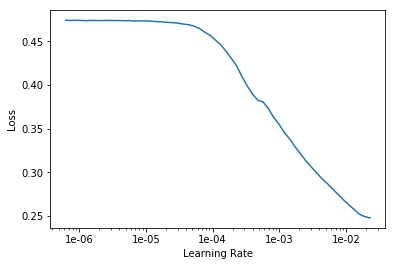

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=2, max_lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.103586,0.063695,02:05
1,0.037606,0.036269,01:25


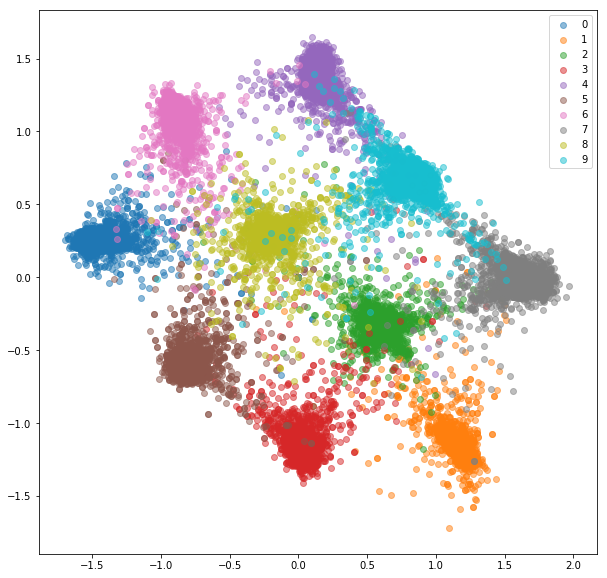

In [ ]:
train_emb_ocl, train_labels_ocl = extract_embeddings(train_dl, model)
plot_embeddings(train_emb_ocl, train_labels_ocl)

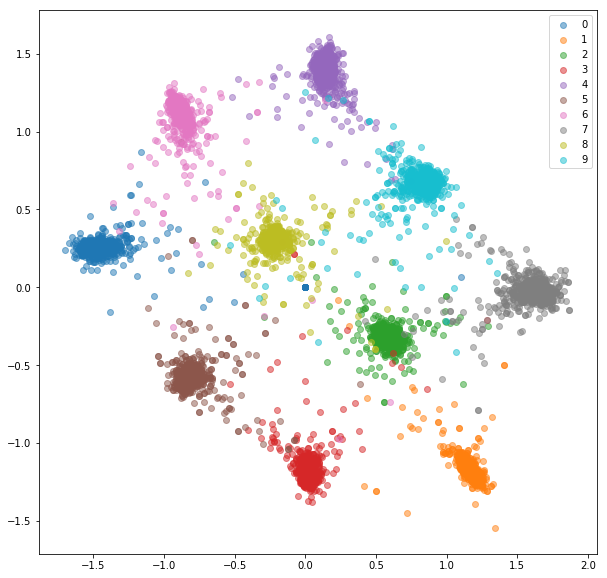

In [ ]:
test_emb_ocl, test_labels_ocl = extract_embeddings(test_dl, model)
plot_embeddings(test_emb_ocl, test_labels_ocl)

# - fin